In [1]:
!pip install -q numerapi pandas lightgbm pyarrow scikit-learn scipy==1.10.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.9/58.9 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 11.3 MB/s eta 0:00:00


In [2]:
from numerapi import NumerAPI
import pandas as pd

DATASET_VERSION = 'v2.0'

# Download data
napi = NumerAPI()
napi.download_dataset(f'signals/{DATASET_VERSION}/train.parquet')
napi.download_dataset(f'signals/{DATASET_VERSION}/validation.parquet')

signals/v2.0/train.parquet: 272MB [00:14, 19.0MB/s]                           
signals/v2.0/validation.parquet: 422MB [00:13, 32.3MB/s]                           


'signals/v2.0/validation.parquet'

In [3]:
train = pd.read_parquet(f'signals/{DATASET_VERSION}/train.parquet')
validation = pd.read_parquet(f'signals/{DATASET_VERSION}/validation.parquet')

# Tickers

The new dataset contains two tickers: `numerai_ticker` and `composite_figi`.

`numerai_ticker` is given for the entire history, but `composite_figi` only goes back to September 2022.

If you have Bloomberg tickers, you can map to `numerai_ticker` by replacing the exchange code with the ISO country code.

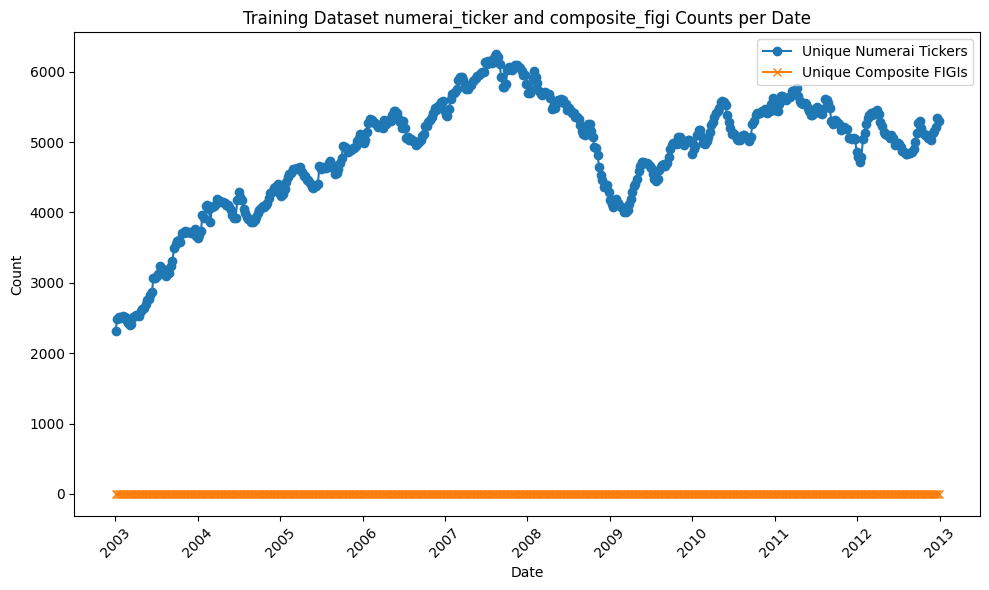

In [4]:
import matplotlib.pyplot as plt

def plot_ticker_counts_per_date(df, title):
    df['date'] = pd.to_datetime(df['date'])

    # Count unique 'numerai_ticker' and 'composite_figi' per 'date'
    nticker_count_per_date = df.groupby('date')['numerai_ticker'].nunique().reset_index(name='numerai_ticker_count')
    figi_count_per_date = df.groupby('date')['composite_figi'].nunique().reset_index(name='figi_count')

    # Merge the counts into a single DataFrame for plotting
    merged_counts = pd.merge(nticker_count_per_date, figi_count_per_date, on='date')

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(merged_counts['date'], merged_counts['numerai_ticker_count'], label='Unique Numerai Tickers', marker='o')
    plt.plot(merged_counts['date'], merged_counts['figi_count'], label='Unique Composite FIGIs', marker='x')

    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Count')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

plot_ticker_counts_per_date(train, 'Training Dataset numerai_ticker and composite_figi Counts per Date')

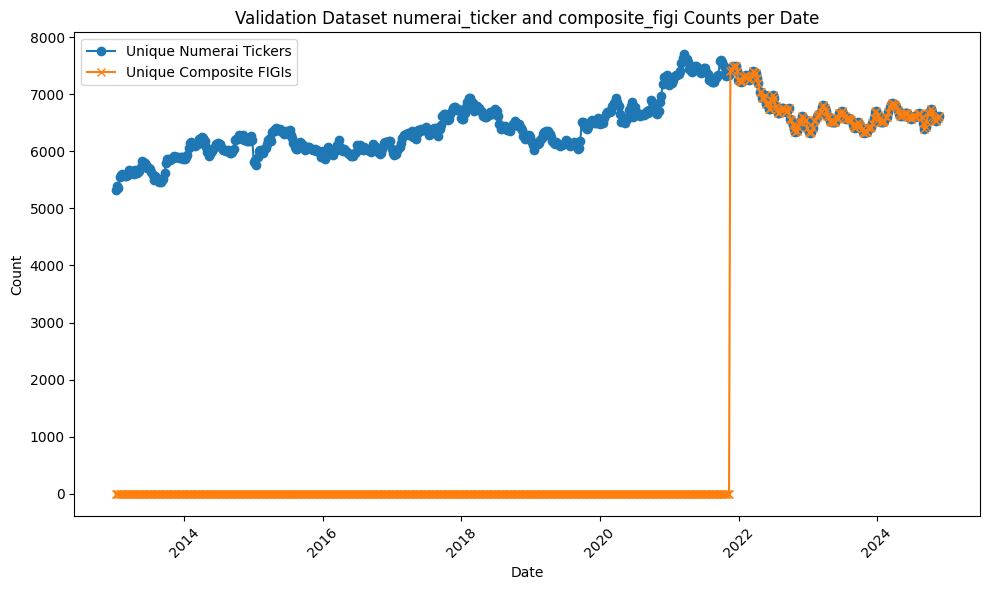

In [5]:
plot_ticker_counts_per_date(validation, 'Validation Dataset numerai_ticker and composite_figi Counts per Date')

## Mapping to `numerai_ticker`

If you have Bloomberg tickers, you can map to `numerai_ticker` by replacing the exchange code with the ISO country code

In [6]:
import random

# Computed using https://stockmarketmba.com/globalstockexchanges.php
# and https://www.isin.net/country-codes/
# Converting Bloomberg exchange code -> Country -> ISO 3166
TICKER_CTRY_MAP = {
    "AU": "AU",
    "AV": "AT",
    "BB": "BE",
    "BZ": "BR",
    "CA": "CA",
    "CB": "CO",
    "CH": "CN",
    "CI": "CL",
    "CN": "CA",
    "CP": "CZ",
    "DC": "DK",
    "EY": "EG",
    "FH": "FI",
    "FP": "FR",
    "GA": "GR",
    "GR": "DE",
    "GY": "DE",
    "HB": "HU",
    "HK": "HK",
    "ID": "IE",
    "IJ": "ID",
    "IM": "IT",
    "IN": "IN",
    "IT": "IL",
    "JP": "JP",
    "KS": "KR",
    "LN": "GB",
    "MF": "MX",
    "MK": "MY",
    "NA": "NL",
    "NO": "NO",
    "NZ": "NZ",
    "PE": "PE",
    "PL": "PT",
    "PM": "PH",
    "PW": "PL",
    "QD": "QA",
    "RM": "RU",
    "SJ": "ZA",
    "SM": "ES",
    "SP": "SG",
    "SS": "SE",
    "SW": "CH",
    "TB": "TH",
    "TI": "TR",
    "TT": "TW",
    "UH": "AE",
    "US": "US",
    "UQ": "US",
}

def map_country_code(row):
    if row["bloomberg_ticker"] is None:
        return None
    split_ticker = row["bloomberg_ticker"].split()
    if len(split_ticker) < 2:
        capture_message(f'No country code for {row["bloomberg_ticker"]}')
        return None

    ticker = split_ticker[0]
    country_code = split_ticker[-1]
    iso_country_code = TICKER_CTRY_MAP.get(country_code)
    return f"{ticker} {iso_country_code}"

# create test dataframe with Bloomberg tickers
df = pd.DataFrame([
  {'bloomberg_ticker': '000640 KS', 'signal': random.random()},
  {'bloomberg_ticker': '1103 TT', 'signal': random.random()},
  {'bloomberg_ticker': 'A2A IM', 'signal': random.random()},
  {'bloomberg_ticker': 'ABBN SW', 'signal': random.random()}
])

# convert to numerai_ticker
df['numerai_ticker'] = df.apply(
    map_country_code, axis=1
)

assert df.iloc[0]['numerai_ticker'] == '000640 KR'
assert df.iloc[1]['numerai_ticker'] == '1103 TW'
assert df.iloc[2]['numerai_ticker'] == 'A2A IT'
assert df.iloc[3]['numerai_ticker'] == 'ABBN CH'

# Features

The V1 features are:
```
feature_adv_20d_factor
feature_beta_factor
feature_book_to_price_factor
feature_country
feature_dividend_yield_factor
feature_earnings_yield_factor
feature_growth_factor
feature_impact_cost_factor
feature_market_cap_factor
feature_momentum_12w_factor
feature_momentum_26w_factor
feature_momentum_52w_factor
feature_momentum_52w_less_4w_factor
feature_ppo_60d_130d_country_ranknorm
feature_ppo_60d_90d_country_ranknorm
feature_price_factor
feature_rsi_130d_country_ranknorm
feature_rsi_60d_country_ranknorm
feature_rsi_90d_country_ranknorm
feature_trix_130d_country_ranknorm
feature_trix_60d_country_ranknorm
feature_value_factor
feature_volatility_factor
```

Features with `{n}(d|w)` in the name (for example, `feature_adv_20d_factor`) are time-series features that are computed over `n` days or `n` weeks.

Features with `country_ranknorm` in the name are grouped by country, then ranked, then gaussianized.

Features with `factor` in the name refer to risk factors that most of the targets are neutral to.

PPO, RSI and TRIX are examples of technical indicators.

PPO is a percentage price oscillator that compares shorter and longer moving averages in a ratio
RSI is the relative strength index usually used as an overbought/oversold indicator
TRIX is a triple exponential moving average indicator usually used as momentum or reversal feature

`momentum_52w_less_4w` refers to one year return of a stock excluding the last 4 weeks.



# Modeling

The V1 dataset includes a small set of features that can be used on its own or in addition to your existing dataset.

In this example, we will show how to use the V1 features to train and submit predictions.

In [7]:
import lightgbm as lgb

feature_cols = [col for col in train.columns if col.startswith('feature_')]

# there are two non-numerical feature cols
feature_cols = [s for s in feature_cols if s not in ("feature_country", "feature_exchange_code")]

# https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html
model = lgb.LGBMRegressor(
  n_estimators=2000,
  learning_rate=0.01,
  max_depth=5,
  num_leaves=2**5-1,
  colsample_bytree=0.1
)

# This will take a few minutes 🍵
model.fit(
  train[feature_cols],
  train["target"]
)

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.458827 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5610
[LightGBM] [Info] Number of data points in the train set: 2536318, number of used features: 22
[LightGBM] [Info] Start training from score 0.500004
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

LGBMRegressor(colsample_bytree=0.1, learning_rate=0.01, max_depth=5,
              n_estimators=2000)

# Live Submission

To make a live submission, you only need to submit a ticker column with its signal.

We accept the following tickers for live submissions:

* cusip
* sedol
* bloomberg_ticker
* composite_figi
* numerai_ticker

In [8]:
napi.download_dataset(f'signals/{DATASET_VERSION}/live.parquet')
live = pd.read_parquet(f'signals/{DATASET_VERSION}/live.parquet')

live['signal'] = model.predict(live[feature_cols])

submission = live[['numerai_ticker', 'signal']]
submission

signals/v2.0/live.parquet: 968kB [00:00, 3.94MB/s]                           


,numerai_ticker,signal
0,000080 KR,0.496785
1,000100 KR,0.505226
2,000120 KR,0.499629
3,000150 KR,0.502670
4,000210 KR,0.489368
...,...,...
6652,ZUO US,0.501888
6653,ZURN CH,0.498486
6654,ZVRA US,0.499622
6655,ZWS US,0.500102


In [10]:
# Save and download your predictions
current_round = napi.get_current_round()
filename = f'signals_{current_round}_live_preds.csv'
submission.to_csv(filename, index=False)

# Download file if running in Google Colab
try:
    from google.colab import files
    files.download(filename)
except:
    pass

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>



Now, visit the [Submissions page](https://signals.numer.ai/submissions) to upload your submissions to your model.

